In [153]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image

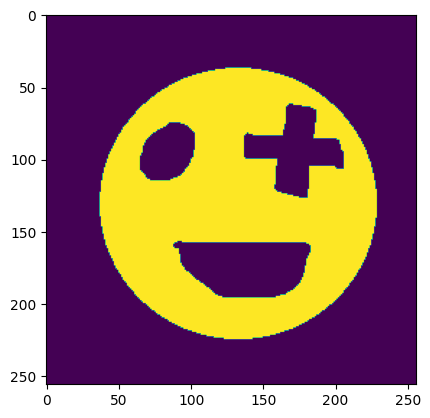

In [154]:
img = Image.open('smiley.png')
img = img.convert('L')
img = img / np.max(img)
plt.imshow(img)

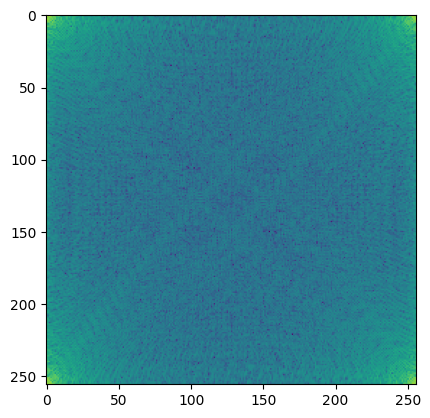

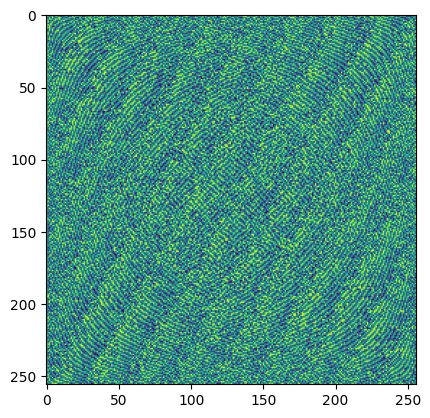

In [155]:
fft = sp.fft.fft2(img)

amp = np.abs(fft)
phase = np.angle(fft)
plt.imshow(np.log(amp))
plt.show()
plt.imshow(phase)

In [156]:
wave_length = sp.constants.speed_of_sound / 40_000
k = 2 * np.pi / wave_length  # wave number
delta = 0.16 / 256

# make propagator
def H(sx, sy, z):
    out = np.zeros((sx, sy), dtype=complex)
    for i in range(sx):
        for j in range(sy):
            k_x = i - sx//2
            k_y = j - sy//2
            k_x = k_x / sx * wave_length / delta
            k_y = k_y / sy * wave_length / delta
            if z < 0: # to prevent overflow
                out[i][j] = np.conj(np.e**(-1j*z*k*np.emath.sqrt(1 - k_x**2 - k_y**2)))
            else:
                out[i][j] = np.e**(1j*z*k*np.emath.sqrt(1 - k_x**2 - k_y**2))
    return sp.fft.fftshift(out)

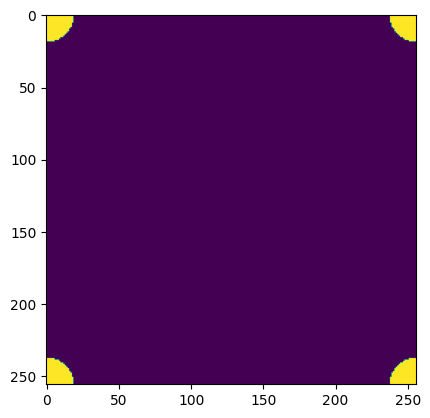

In [157]:
prop = H(256, 256, 0.16)
fft_prop = fft * prop
plt.imshow(np.abs(prop))

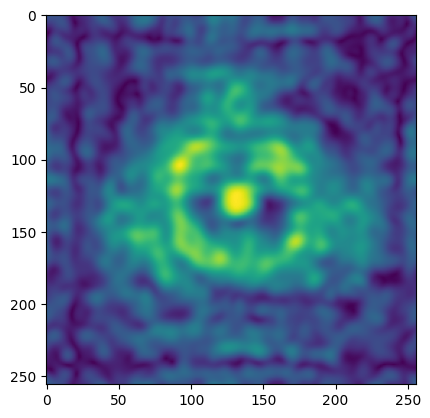

In [158]:
source = sp.fft.ifft2(fft_prop)
plt.imshow(np.abs(source))

In [159]:
fft = sp.fft.fft2(source)
backprop = fft * H(256, 256, -0.16)
source = sp.fft.ifft2(backprop)

In [160]:
phase_res = 16
amp_res = 16
fprop = H(256, 256, -0.16)
bprop = H(256, 256, 0.16)

target = img

# circular mask
jump = 256 // 16
circle = np.zeros((jump, jump))
for x, y in np.ndindex(circle.shape):
    if np.sqrt((x+0.5-jump/2)**2 + (y+0.5-jump/2)**2) < jump/2:
        circle[x, y] = 1
        
circular_mask = np.zeros(target.shape)
for x, y in np.ndindex(circle.shape):
    x = x*jump
    y = y*jump
    circular_mask[x:x+jump, y:y+jump] = circle

for _ in range(50):
    target_fft = sp.fft.fft2(target)
    source_fft = target_fft * fprop
    
    source = sp.fft.ifft2(source_fft)
    
    zoomed = sp.ndimage.zoom(source, 16 / 256)
    zoomed = zoomed / np.max(np.abs(zoomed)) # normalize
    
    phase = np.round(np.angle(zoomed) / (2*np.pi) * phase_res) / phase_res * 2 * np.pi
    # TODO: maybe turn on all emitters for no amplitude res
    amp = np.round(np.abs(zoomed) * amp_res) / amp_res
    
    zoomed = amp * np.e**(1j*phase)
    # zoomed = np.e**(1j*phase)
    
    unzoomed = sp.ndimage.zoom(zoomed, 256 / 16, order=1)
    # unzoomed = unzoomed * circular_mask
    
    # backprop
    source_fft = sp.fft.fft2(unzoomed)
    target_fft = source_fft * bprop
    target_real = sp.fft.ifft2(target_fft)
    target = img * np.e**(1j*np.angle(target_real))

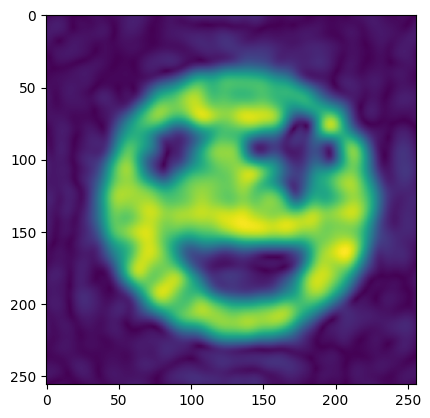

In [161]:
plt.imshow(np.abs(target_real))

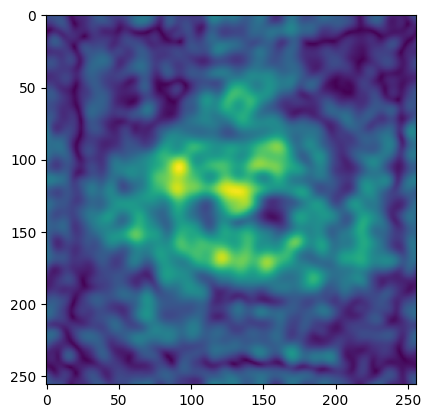

In [162]:
plt.imshow(np.abs(source))

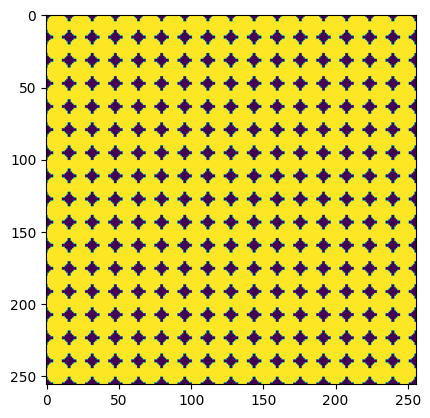

In [122]:
plt.imshow(circular_mask)